Notebook for elaboration of grid frames and comparison of Java and C results. First we may want to import the libraries for data manipulation.

In [1]:
import pandas as pd
import math

# Imports for the first implementation of the gif
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Imports for the second implementation of the gif
#from matplotlib import cm
#from celluloid import Camera
#import sys
#import seaborn as sns

And define the Java and C output.txt paths.

In [2]:
JAVA_OUT_PATH = '../ns_java/output.txt'
C_OUT_PATH = './output.txt'

Then we're going to define the amount of points per frame, previously defined in the C program, and read with Pandas the csv output.

In [3]:
FRAME_POINTS = 6724

raw_C = []
C_data = []
raw_C = pd.read_csv(C_OUT_PATH, names=['x', 'y', 'd'])

Size of raw output.txt:

In [4]:
print(len(raw_C))

342924


An insight in how the output file was written; x and y are the coordinates of each cell, while d is the relative density of that region.

In [5]:
raw_C.head()

,x,y,d
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0


For consistency, we're also picking up the Java application output and checking whether it corresponds to the C one. This has to be done only if parameters were equal between the simulations.

In [12]:
EQUAL_PARAMETERS = True
raw_Java = []

if EQUAL_PARAMETERS:
    raw_Java = pd.read_csv(JAVA_OUT_PATH, names=['x', 'y', 'd'])
    
# DOES NOT WORK FOR NOW, Y VALUES FOR THE C OUTPUT ARE INVERTED W.R.T. THE JAVA ONES
# REVERT THEM IN ANOTHER STRUCTURE AND USE THAT FOR THE COMPARISON

# EDIT: SLOW AS HELL AND EVEN WRONG IN THE END

# Now we're swapping density values to make the C ones correspond to the Java ones.
# To do so, we iterate over the first half of each frame and swap the density values
# with rows that have the same x and an y value equal to 82(the square boundary) minus
# the current y, to find the exact same on the other side of the world.

bounds = math.sqrt(FRAME_POINTS)
start = 0
end = FRAME_POINTS

while (start != len(raw_C)):
        
    # Iterate over the first half of each frame
    while (start < (end-FRAME_POINTS/2)):
        this_x = raw_C.x[start]
        this_y = raw_C.y[start]
        this_d = raw_C.d[start]
        
        # Get the value on the other half of the frame                   -1 because from 82 we go to 81
        tmp = raw_C.loc[(raw_C['x'] == this_x) & (raw_C['y'] == int((bounds-1)-this_y)) & (start < raw_C.index) & (raw_C.index < end)]
        
        # Save the actual density on the other half's cell
        raw_C.loc[tmp.index[0]]['d'] = this_d
        
        # Save the other half's cell density to the actual density
        raw_C.d[start] = tmp.d[tmp.index[0]]
        
        start += 1
    
    start = end
    end += FRAME_POINTS
    print(start)

# This shows the differencies(if any) between the two dataframes
print(raw_C.compare(raw_Java))

# True if they're equal
raw_C.equals(raw_Java)

6724
13448
20172
26896
33620
40344
47068
53792
60516
67240
73964
80688
87412
94136
100860
107584
114308
121032
127756
134480
141204
147928
154652
161376
168100
174824
181548
188272
194996
201720
208444
215168
221892
228616
235340
242064
248788
255512
262236
268960
275684
282408
289132
295856
302580
309304
316028
322752
329476
336200
342924
            d      
         self other
3321    255.0   0.0
5017    255.0   0.0
5067    255.0   0.0
8630      0.0  15.0
8713      0.0  15.0
...       ...   ...
342655    0.0   4.0
342736    0.0   1.0
342737    0.0   2.0
342738    0.0   1.0
342819    0.0   1.0

[16576 rows x 2 columns]


False

Now let's put the raw data into the structure we'll be using to plot the frames; with FRAME_POINTS we can divide the output into single frames.

In [7]:
start = 0
end = FRAME_POINTS

while (start != len(raw_C)):
    frame = {"x": raw_C.x[start:end], "y": raw_C.y[start:end], "density": raw_C.d[start:end]}
    C_data.append(frame)
    start = end
    end += FRAME_POINTS

Amount of frames:

In [8]:
print(len(C_data))

51


This number includes the initial grid state plus the n ticks of the simulation.

Points per frame:

In [9]:
print(len(C_data[0]['x']))

6724


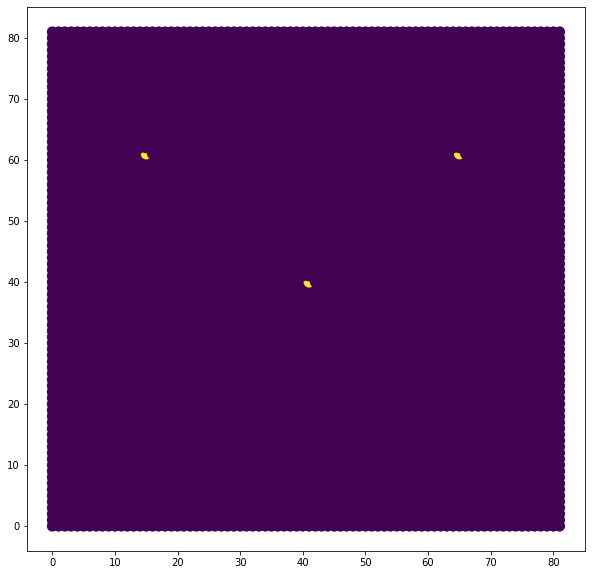

MovieWriter ffmpeg unavailable; using Pillow instead.


"\n# NOT-SO-GOOD VERSION\nnumpoints = 6724\npoints = [data[0]['x'], data[0]['y']]\ncolors = data[0]['density']\ncamera = Camera(plt.figure())\nfor i in range(len(data)):\n    points = [data[i]['x'], data[i]['y']]\n    colors = data[i]['density']\n    plt.scatter(*points, c=colors, s=100)\n    camera.snap()\nanim = camera.animate(blit=True)\nanim.save('scatter.gif')\n"

In [10]:
'''
# SEQUENTIAL PLOT
for i in range(len(data)):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(data[i]['x'], data[i]['y'], c=data[i]['density'])
    ax.set_aspect(1)

    plt.show()
'''

# BETTER VERSION SO FAR
def main():
    numframes = 51   # len(data)
    numpoints = 6724
    color_data = C_data[0]['density']  #np.random.random((numframes, numpoints))  # THIS INSTEAD DOES SOMETHING SIMILAR
    x, y, c = C_data[0]['x'], C_data[0]['y'], C_data[0]['density']

    fig = plt.figure(figsize=(10, 10))
    scat = plt.scatter(x, y, c=c, s=100)

    ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
                                  fargs=(color_data, scat))
    plt.show()
    ani.save('animation.gif')

def update_plot(i, custom_data, scat):
    scat.set_offsets(np.c_[C_data[i]['x'], C_data[i]['y']])
    scat.set_array(C_data[i]['density'])
    return scat,

main()


'''
# NOT-SO-GOOD VERSION
numpoints = 6724
points = [data[0]['x'], data[0]['y']]
colors = data[0]['density']
camera = Camera(plt.figure())
for i in range(len(data)):
    points = [data[i]['x'], data[i]['y']]
    colors = data[i]['density']
    plt.scatter(*points, c=colors, s=100)
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.gif')
'''